In [45]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, preprocessing, model_selection, metrics
from scipy.stats import sem #standard deviation
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import LeaveOneOut as loo
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from __future__ import division

In [5]:
mat = scipy.io.loadmat('HAR_database.mat')
train = mat['database_training']
train = map(lambda x : np.concatenate([np.transpose(x[0]),np.transpose(x[1])],axis=1), train)
people_ix = map(lambda x: len(x), train) # note here I'm using the already TRANSPOSED train

# create a column to identify whom person do the records belong to
ix = list(reversed([(people_ix[i]+sum(people_ix[0:i])) for i in reversed(range(0,len(people_ix)))]))
people_id = np.zeros(ix[-1])
people_id[0:ix[0]]=1
for i in range(1,8):
    people_id[ix[i-1]:ix[i]]= i+1

data = pd.DataFrame(train[0])
for i in range(1,8):
    data = data.append(pd.DataFrame(train[i]))
data.columns = [1,2,3,4,5,'label']
data['label']= data['label'].astype(int)
data['person_id'] = people_id.astype(int)
data.to_csv('data.csv',index= False, header = True)
data.head()

,1,2,3,4,5,label,person_id
0,0.024173,0.594417,-0.022736,0.111962,0.060499,3,1
1,0.019905,0.602472,-0.012875,0.103796,0.055157,3,1
2,0.034749,0.525821,-0.020016,0.103193,0.057541,3,1
3,0.059832,0.621057,-0.026841,0.104378,0.063853,3,1
4,0.044743,0.653001,-0.014540,0.103560,0.066084,3,1


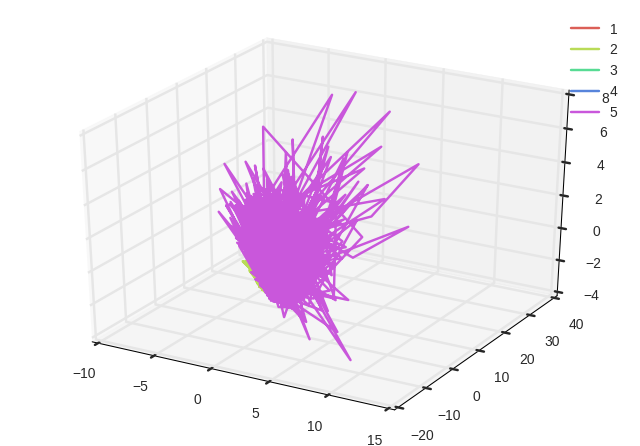

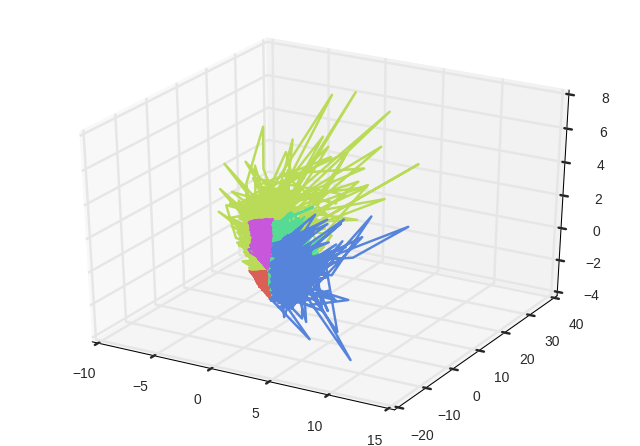

In [36]:
import hypertools as hyp
%matplotlib inline
hyp.plot(data[[1,2,3,4,5]],'o',group= data.label, legend=list(set(data.label)))

cluster_labels = hyp.tools.cluster(data, n_clusters=5)
hyp.plot(data, group=cluster_labels)


In [ ]:
# INTERESTING! LET'S TRY KNN
from sklearn import 

In [4]:
# FIRST I TUNE HYPERPARAMS

# RBF KERNEL 

p1_ix = data.loc[data['person_id']==1].index.tolist()

# a good idea is to scale the features
xTrain_scaled = preprocessing.scale(data[[1,2,3,4,5]], axis=1)

c = [1,10,100,1000]
yy = np.logspace(-3,3, num=5) #gamma in range (10e-3 , 10e3)

param_grid = {'C': c, 'gamma': yy}

np.random.seed(42)
clf = GridSearchCV(svm.SVC(kernel='rbf'), 
                   param_grid,
                   scoring='accuracy',
                   cv=3 , n_jobs=-1, verbose=1)

clf.fit(xTrain_scaled[p1_ix],data['label'].iloc[p1_ix])

print 'With the parametes %s, \ntrain score is %s' %(clf.best_params_, round(clf.best_score_,3))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.6min finished


With the parametes {'C': 10, 'gamma': 1.0}, 
train score is 0.883


In [ ]:
# POLYNOMIAL KERNEL

c = [1,10,100,1000]
M = np.arange(7,10,1)

param_grid = {'C': c, 'degree': M}

np.random.seed(42)
clf = GridSearchCV(svm.SVC(kernel='poly', gamma=1, coef0=1), 
                   param_grid,
                   scoring='accuracy',
                   cv=3 , n_jobs=-1, verbose=1)

#clf.fit(xTrain_scaled[p1_ix],data['label'].iloc[p1_ix])
# too long...
print 'With the parametes %s, \ntrain score is %s' %(clf.best_params_, round(clf.best_score_,3))

In [49]:
clf_rbf = svm.SVC(kernel='rbf',C=10, gamma=1)

splits = loo().split(range(1,9))
    
for people_train, person_val in splits:
    scaled_train = [xTrain_scaled[people_ix2[person_train]] for person_train in people_train]
    label_train = [data['label'].iloc[people_ix2[person_train]] for person_train in people_train]
    
    xTr = pd.DataFrame(scaled_train[0])
    yTr = pd.DataFrame(label_train[0])
    for i in range(1,7):
        xTr = xTr.append(pd.DataFrame(scaled_train[i]))
        yTr = yTr.append(pd.DataFrame(label_train[i]))
    
    
    scaled_val = xTrain_scaled[people_ix2[person_val]]
    label_val = data['label'].iloc[people_ix2[person_val]]

    model = clf_rbf.fit(xTr, yTr)
    pred = model.predict(scaled_val)
    
    target_names = ['act 1', 'act 2', 'act 3', 'act 4', 'act 5']
    print 'Validated on person %s:' %(person_val[0]+1)
    print classification_report(label_val, pred, target_names=target_names)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Validated on person 1:
             precision    recall  f1-score   support

      act 1       0.75      0.31      0.44       527
      act 2       0.82      0.81      0.82      3563
      act 3       0.89      0.94      0.92      5800
      act 4       0.98      0.99      0.99      5317
      act 5       1.00      1.00      1.00      2529

avg / total       0.92      0.92      0.92     17736

Validated on person 2:
             precision    recall  f1-score   support

      act 1       0.72      0.31      0.44       527
      act 2       0.79      0.82      0.80      3563
      act 3       0.90      0.92      0.91      6475
      act 4       0.98      0.99      0.99      5317
      act 5       1.00      1.00      1.00      2529

avg / total       0.91      0.91      0.91     18411

Validated on person 3:
             precision    recall  f1-score   support

      act 1       0.75      0.31      0.44       527
      act 2       0.82      0.81      0.82      3563
      act 3       0.89 

***

In [51]:
nb = GaussianNB()

# index that contains all the indices of people (the original just the last point)
people_ix2 = [data.loc[data['person_id']==person].index.tolist() for person in range(1,9)]

splits = loo().split(range(1,9))

print'Leave-One(Person)-Out cross validaton to study\n the performance of a Naive Bayes Classifier'
for people_train, person_val in splits:
    scaled_train = [xTrain_scaled[people_ix2[person_train]] for person_train in people_train]
    label_train = [data['label'].iloc[people_ix2[person_train]] for person_train in people_train]
    
    xTr = pd.DataFrame(scaled_train[0])
    yTr = pd.DataFrame(label_train[0])
    for i in range(1,7):
        xTr = xTr.append(pd.DataFrame(scaled_train[i]))
        yTr = yTr.append(pd.DataFrame(label_train[i]))
    
    
    scaled_val = xTrain_scaled[people_ix2[person_val]]
    label_val = data['label'].iloc[people_ix2[person_val]]

    model = nb.fit(xTr, yTr)
    pred = model.predict(scaled_val)
    
    target_names = ['act 1', 'act 2', 'act 3', 'act 4', 'act 5']
    print 'Validated on person %s:' %(person_val[0]+1)
    print classification_report(label_val, pred, target_names=target_names)

print 'fails in detecting running activities...\n'


Leave-One(Person)-Out cross validaton to study
 the performance of a Naive Bayes Classifier
Validated on person 1:
             precision    recall  f1-score   support

      act 1       0.00      0.00      0.00       527
      act 2       0.72      0.67      0.69      3563
      act 3       0.81      0.91      0.85      5800
      act 4       0.98      0.99      0.99      5317
      act 5       1.00      0.99      1.00      2529

avg / total       0.84      0.87      0.86     17736

Validated on person 2:
             precision    recall  f1-score   support

      act 1       0.00      0.00      0.00       527
      act 2       0.61      0.68      0.64      3563
      act 3       0.81      0.82      0.82      6475
      act 4       0.98      0.99      0.99      5317
      act 5       1.00      0.99      1.00      2529

avg / total       0.82      0.84      0.83     18411



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Validated on person 3:
             precision    recall  f1-score   support

      act 1       0.00      0.00      0.00       527
      act 2       0.72      0.67      0.69      3563
      act 3       0.80      0.90      0.85      5504
      act 4       0.98      0.99      0.99      5317
      act 5       1.00      0.99      1.00      2529

avg / total       0.84      0.87      0.85     17440

Validated on person 4:
             precision    recall  f1-score   support

      act 1       0.00      0.00      0.00       527
      act 2       0.70      0.67      0.69      3563
      act 3       0.81      0.89      0.85      5890
      act 4       0.98      0.99      0.99      5317
      act 5       1.00      0.99      1.00      2529

avg / total       0.84      0.87      0.85     17826

Validated on person 5:
             precision    recall  f1-score   support

      act 1       0.00      0.00      0.00       527
      act 2       0.72      0.68      0.69      3563
      act 3       0.78 

***
Neural-Networks

In [58]:
# Multi-layer Perceptron
xTrain_scaled = preprocessing.scale(data[[1,2,3,4,5]], axis=1)

# index for person 1, to spare time
p1_ix = data.loc[data['person_id']==1].index.tolist()

hl = [(5,),(50,50,50,50,50),(50,8),(50,25,5),(10,10,10,10,10),(100,100,100,100,100)]
act = ['logistic', 'tanh', 'relu']

param_grid = {'hidden_layer_sizes':hl, 'activation':act}

np.random.seed(42)
clf = GridSearchCV(MLPClassifier(solver='adam'), 
                   param_grid,
                   scoring='accuracy',
                   cv=5, n_jobs=-1, verbose=1)


clf.fit(xTrain_scaled[p1_ix],data['label'].iloc[p1_ix])

print 'With the parametes %s, \ntrain score is %s' %(clf.best_params_, round(clf.best_score_,3))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 20.7min finished


With the parametes {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10, 10, 10)}, 
train score is 0.903


In [59]:
clf = MLPClassifier(solver='adam', 
                    activation='tanh',
                    hidden_layer_sizes=(10,10,10,10,10))

splits = loo().split(range(1,9))
    
for people_train, person_val in splits:
    scaled_train = [xTrain_scaled[people_ix2[person_train]] for person_train in people_train]
    label_train = [data['label'].iloc[people_ix2[person_train]] for person_train in people_train]
    
    xTr = pd.DataFrame(scaled_train[0])
    yTr = pd.DataFrame(label_train[0])
    for i in range(1,7):
        xTr = xTr.append(pd.DataFrame(scaled_train[i]))
        yTr = yTr.append(pd.DataFrame(label_train[i]))
    
    
    scaled_val = xTrain_scaled[people_ix2[person_val]]
    label_val = data['label'].iloc[people_ix2[person_val]]
    
    model = clf.fit(xTr, yTr)
    pred = model.predict(scaled_val)
    
    target_names = ['act 1', 'act 2', 'act 3', 'act 4', 'act 5']
    print 'Validated on person %s:' %(person_val[0]+1)
    print classification_report(label_val, pred, target_names=target_names)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Validated on person 1:
             precision    recall  f1-score   support

      act 1       0.69      0.26      0.38       527
      act 2       0.80      0.81      0.81      3563
      act 3       0.89      0.93      0.91      5800
      act 4       0.99      0.99      0.99      5317
      act 5       1.00      1.00      1.00      2529

avg / total       0.91      0.92      0.91     17736

Validated on person 2:
             precision    recall  f1-score   support

      act 1       0.60      0.32      0.42       527
      act 2       0.76      0.84      0.80      3563
      act 3       0.91      0.90      0.90      6475
      act 4       0.99      0.99      0.99      5317
      act 5       1.00      1.00      1.00      2529

avg / total       0.91      0.91      0.91     18411

Validated on person 3:
             precision    recall  f1-score   support

      act 1       0.70      0.30      0.42       527
      act 2       0.80      0.82      0.81      3563
      act 3       0.89 

***
***
### FINAL CLASSIFIER CHOSEN. SVM

In [86]:
test = mat['database_test']
test = map(lambda x : np.transpose(x[0]), test)
xTest1 = pd.DataFrame(test[0])
xTest2 = pd.DataFrame(test[1])

xTest1.columns = [1,2,3,4,5]
xTest2.columns = [1,2,3,4,5]

xTest1_scaled = preprocessing.scale(xTest1, axis=1)
xTest2_scaled = preprocessing.scale(xTest2, axis=1)
xTrain_scaled = preprocessing.scale(data[[1,2,3,4,5]], axis=1)


clf_rbf = svm.SVC(kernel='rbf',C=10, gamma=1)
model = clf_rbf.fit(xTrain_scaled, data['label'])

predictions1 = model.predict(xTest1_scaled)
predictions2 = model.predict(xTest2_scaled)

In [87]:
predictions1

array([3, 3, 3, ..., 4, 4, 4])

In [88]:
predictions2

array([2, 3, 4, ..., 3, 3, 3])

In [89]:
predictions = np.array([predictions1,predictions2])

In [90]:
predictions

array([array([3, 3, 3, ..., 4, 4, 4]), array([2, 3, 4, ..., 3, 3, 3])], dtype=object)

In [93]:
scipy.io.savemat('HAR_testPredictions.mat',{'predictions':predictions})